<a href="https://colab.research.google.com/github/s2cretjuju/first-repository/blob/master/ds6/%5B%EB%A9%94%EC%9D%B8_%ED%80%98%EC%8A%A4%ED%8A%B8(5)%5D_20251112_%EC%A3%BC%ED%83%9D_%EA%B0%80%EA%B2%A9_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Main Quest(5): 주택 가격 예측 모델**

* 예측할 값(y): SalePrice
* 모델 평가 지표: RMSE - 숫자가 낮을수록 더 정확한 모델

#**1단계: 데이터 호출 및 확인**

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (1168, 81)
Test shape: (292, 80)


In [220]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000
3,239,20,RL,93.0,12030,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2007,New,Partial,318000
4,891,50,RL,60.0,8064,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,2000,7,2007,WD,Normal,122900


In [221]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

* LotFrontage(도로에 접한 토지 길이), Electrical(전기 시스템 종류)을 제외한 null값이 있는 컬럼들은 데이터가 누락된 것이 아니라 실제로 없는 것을 의미하는 것이므로 전처리 과정에 손을 봐야할 필요가 있음 (0이나 None)

* 도로에 접한 토지의 길이가 없을 수는 없으므로, LotFrontage는 누락된 값이 맞음 - 중앙값으로 채우기

* Electrical은 결측치가 1개이므로 최빈값으로 채움

##**1-1. SalePrice (타겟변수) 분포 파악**

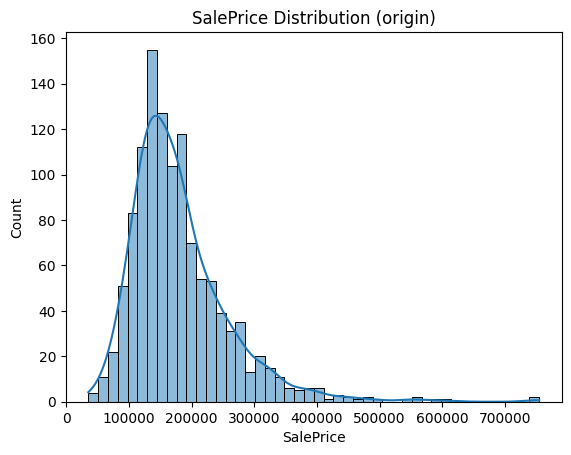

In [222]:
# 1. SalePrice (타겟변수) 분포 확인
sns.histplot(train['SalePrice'], kde =True)
plt.title('SalePrice Distribution (origin)')
plt.show()

* 오른쪽으로 꼬리가 긴(Right-skewed) 분포를 보임 - 대부분의 주택 가격은 특정 범위에 몰려있고, 소수의 매우 비싼 주택이 존재
* 대부분의 주택 가격은 10만에서 20만 달러 사이에 집중
* 40만 달러 이상의 고가 주택들이 소수 존재하면서 데이터의 전체 분포를 오를쪽으로 끌어당김

    ➡️ 많은 머신러닝 모델(특히 선형 회귀 모델)은 타겟 변수(y)가 정규분포일 때 더 정확한 예측을 하기 때문에 로그 변환을 통해 정규분포 형태로 바꾸어 줌

Train shape: (1168, 81)
Test shape: (292, 80)


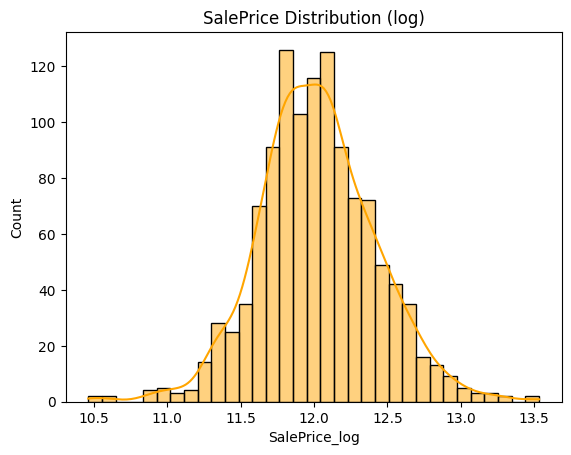

In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
# 2. SalePrice 로그 변환
# 분포가 오른쪽으로 치우쳐 있으므로, 로그 변환 (np.log1psms log(1+x)로 0값을 안전하게 처리)
train['SalePrice_log'] = np.log1p(train['SalePrice'])

# 3. 로그 변환 후 분포 확인
sns.histplot(train['SalePrice_log'], kde = True, color = 'orange')
plt.title('SalePrice Distribution (log)')
plt.show()

이전의 오른쪽으로 길게 쏠렸던 그래프와 달리, 거의 완벽한 정규분포의 형태를 띰

##**1-2. 주요 변수와 SalePrice 관계 파악**

---

1. 면적이 넓을수록 비쌀 것이다
2. 신축일수록 비쌀 것이다
3. 주차 공간이 많을수록 비쌀 것이다
4. 동네 위치에 따라 가격 차이가 있을 것이다
5. 전반적인 품질이 좋을수록 비쌀 것이다

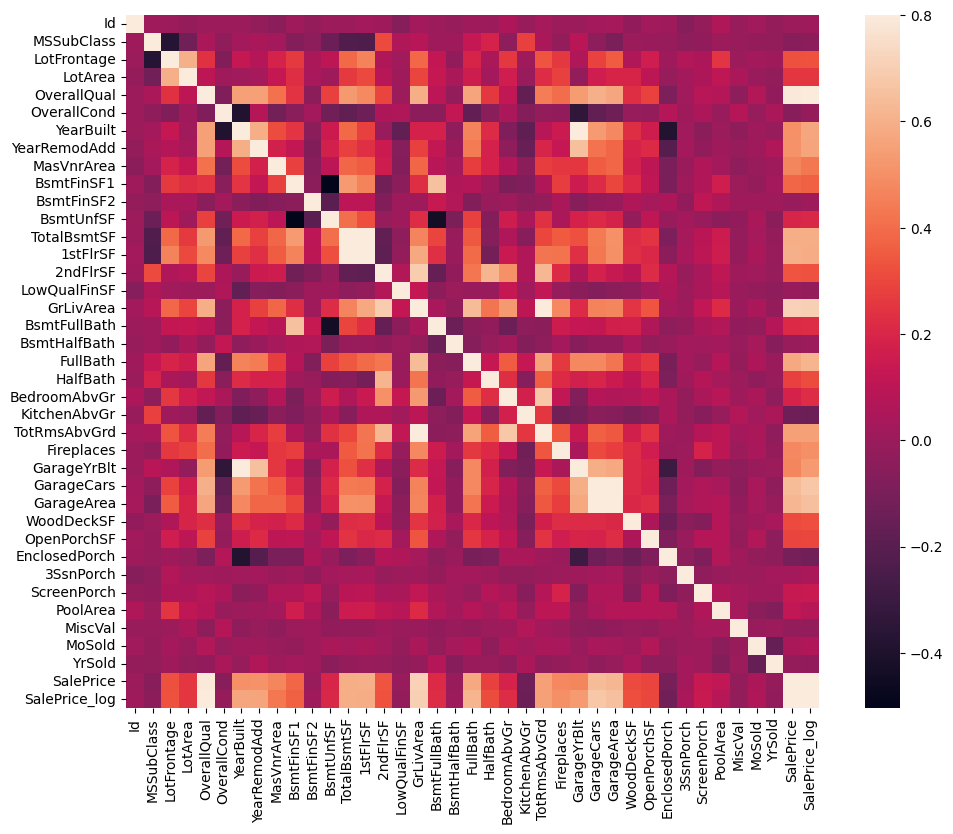

In [224]:
# 숫자형 변수들만 선택
numeric_features = train.select_dtypes(include = [np.number])

# 상관계수 계산
corrmat = numeric_features.corr()

# 히트맵 그리기
plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, annot = False, vmax = .8, square = True) # annot = True로 하면 숫자도 표시됨
plt.show()

1. OverallQual(전반적인 품질), GrLivArea(지상층 면적), GaragrCars(차고 차량 수), GarageArea(차고 면적), TotalBsmSF(총 지하실 면적), 1stFlrSF(1층 면적), FullBath(메인 화장실 개수), YearBuilt(건축 연도), YearRemodAdd(리모델링 연도)의 변수들이 SalePrice와 높은 상관관계를 가지는 것으로 확인

    **➡️ 집의 품질, 크기(지상/지하/차고 등), 연식이 가격에 큰 영향을 미친다고 판단 가능**

---

2. GarageCars와 GarageArea의 상관관계가 매우 높음
    
    **➡️ 차고 면적이 넓으면 당연히 주차 가능 대수도 많음. 거의 동일한 정보를 담고 있음**

---

3. GrLiveArea 와 TotRmAbvGrd의 상관관계 매우 높음

    **➡️ 면적이 넓으면 방 개수도 많음**

  **⚠️ 변수 간 상관관계가 높으면 다중공선성 문제로 모델 성능 저하 ⚠️**

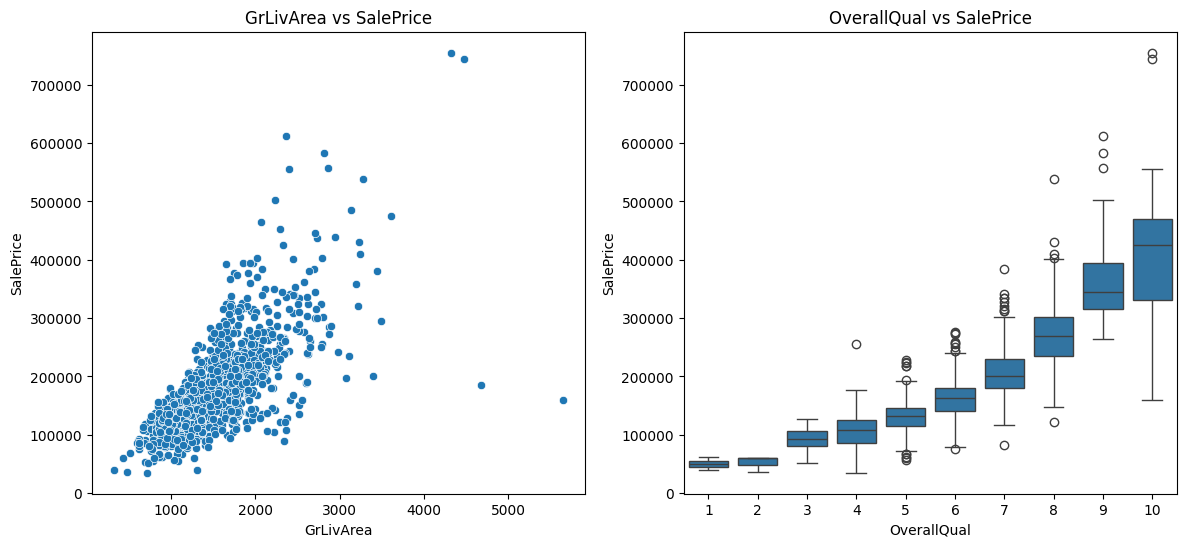

In [225]:
# 숫자형 변수 vs SalePrice (산점도)
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14, 6))
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'], ax = ax1)
ax1.set_title('GrLivArea vs SalePrice')

# 범주형 변수 vs SalePrice (박스 플롯)
sns.boxplot(x = train['OverallQual'], y = train['SalePrice'], ax = ax2)
ax2.set_title('OverallQual vs SalePrice')
plt.show()

**1. GrLivArea (지상층 면적) vs SalePrice 산점도**
   
    면적이 넓어질수록 가격이 높아지는 양의 상관관계를 보임
    면적은 4,000-5,000ft로 넓은데, 가격은 20만 달러 이하로 비정상적으로 저렴한 데이터 포인트가 포착
    
    ➡️ "면적이 크면 비싸다"라는 일반적인 패턴 학습을 방해하는 요소로 이상치를 제거할 필요 有

**2. OverallQual (전반적인 품질) vs SalePrice 박스 플롯**

    품질 등급(1-10)이 높아질수록 주택 가격의 중앙값과 가격 범위가 매우 규칙적으로 상승

    ➡️ Overall은 SalePrice를 예측하는 데 중요한 변수

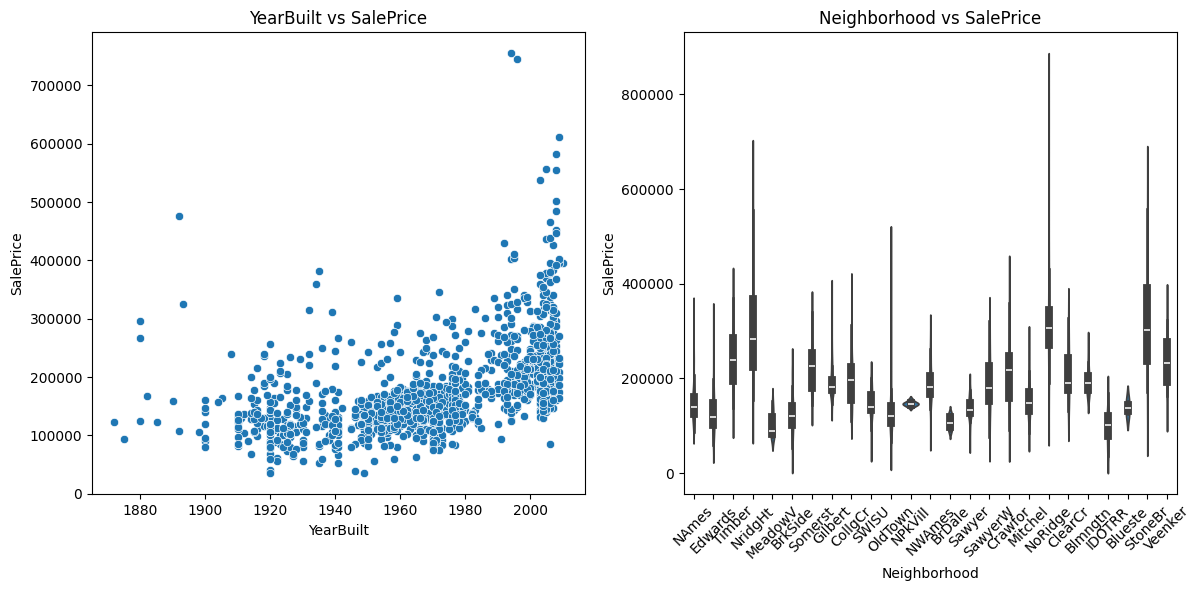

In [226]:
# YearBuilt vs SalePrice
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14, 6))
sns.scatterplot(x = train['YearBuilt'], y = train['SalePrice'], ax = ax1)
ax1.set_title('YearBuilt vs SalePrice')

# Neighborhood vs SalePrice
sns.violinplot(x = train['Neighborhood'], y = train['SalePrice'], ax = ax2)
plt.xticks(rotation = 45)
ax2.set_title('Neighborhood vs SalePrice')
plt.show()

* 신축일수록 비싼 것으로 확인
* 동네에 따라 가격이 천차만별

#**2단계: 데이터 전처리**

더러운 원본 데이터를 모델이 학습할 수 있도록 깨끗한 숫자형 데이터로 가공

In [227]:
# 학습 데이터 개수 저장 및 타겟 변수 분리
ntrain = train.shape[0]
y_train = train['SalePrice_log'].values # 타겟 변수 (로그 변환)
train_id = train['Id']
test_id = test['Id']

##**2-1. 이상치 처리**

In [228]:
# 1. EDA에서 발견한 GrLivArea 이상치 제거
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)
train = train.reset_index(drop = True)
ntrain = train.shape[0] # 이상치 제거 후 개수 다시 저장
y_train = train['SalePrice_log'].values # 타겟 변수도 다시 정의

# 2. 학습/테스트 데이터 합치기 (전처리를 한 번에 적용하기 위함)
all_data = pd.concat((train.drop(['Id', 'SalePrice', 'SalePrice_log'], axis = 1),
                     test.drop('Id', axis = 1))).reset_index(drop = True)

print(f"All data shape: {all_data.shape}")

All data shape: (1458, 79)


원본 학습 데이터 1168개에서 이상치 3개를 제거한 1166개 (ntrain 값) + 테스트 데이터 292개

원본 81개 컬럼에서 Id와 SalePrice 2개를 제외

##**2-2. 결측치 처리**

In [229]:
# 1. 'None'으로 채우기
cols_fill_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                  'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                  'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'MasVnrType']

for col in cols_fill_none:
  all_data[col] = all_data[col].fillna('None')

# 2. 0으로 채우기 (면적/개수 등 '없음'이 0인 경우)
cols_fill_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
                  'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath',
                  'BsmtHalfBath', 'MasVnrArea']

for col in cols_fill_zero:
  all_data[col] = all_data[col].fillna(0)

# 3. 최빈값으로 채우기
cols_fill_mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
                  'Exterior2nd', 'SaleType', 'Utilities']

for col in cols_fill_mode:
  # mode()는 Seies를 반환하므로 [0]으로 첫 번째 값(최빈값)을 선택
  all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# 4. 'LotFrontage' 누락 값을 동네별 중앙값으로 채우기
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# 5. 모든 결측치가 처리되었는지 최종 확인
print(f"남아있는 결측치 개수: {all_data.isnull().sum().sum()}")
# 첫 번째 sum()으로 각 컬럼별 결측치 개수를 센 후,두 번째 sum()으로 데이터 전체의 결측치 개수를 셈

남아있는 결측치 개수: 0


##**2-3. 인코딩**
모델이 이해할 수 있도록 문자열 데이터를 숫자형으로 바꿔줌

In [230]:
# pd.get_dummies는 'object' 타입의 모든 문자열 컬럼을
# 'Neighborhood_A', Neighborhood_B' 같은 0과 1로 된 여러 개의 열로 변환 (원-핫 인코딩)
all_data_processed = pd.get_dummies(all_data)

##**2-4. 스케일링**
Lasso나 Ridge 같은 선형 모델을 위해 필요

In [231]:
# StandardScaler는 모든 숫자형 변수의 평균을 0, 표준편차를 1로 맞춤
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_data_processed[all_data_processed.columns] = scaler.fit_transform(all_data_processed)

In [232]:
# 데이터 다시 분리
train_processed = all_data_processed[:ntrain]
test_processed = all_data_processed[ntrain:]

print(f"전처리 후 학습 데이터 shape: {train_processed.shape}")
print(f"전처리 후 테스트 데이터 shape: {test_processed.shape}")

전처리 후 학습 데이터 shape: (1166, 301)
전처리 후 테스트 데이터 shape: (292, 301)


#**3단계: 모델 선택 및 비교 (3개 이상)**

In [233]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# 교차 검증 (Cross-Validation) 설정 (데이터를 5조각으로 나눔)
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

# RMSE를 계산하는 함수 정의 (로그 변환된 y_train 기준)
def rmse_cv(model, X, y):
  # scikit-learn은 RMSE를 직접 지원하지 않고, "음수 MSE"를 사용
  # (-) 점수에 다시 (-)를 붙여 양수 MSE로 만들고, np.sqrt()로 루트를 씌워 RMSE로 만듦
  rmse = np.sqrt(-cross_val_score(model, X, y,
                                  scoring = 'neg_mean_squared_error', cv = kf))
  return rmse

##**3-1. 모델 1: Ridge - 선형 모델 계열**
가장 기본적이면서도 강력한 선형 모델.

원-핫 인코딩으로 변수가 많아졌을 때, 과적합을 방지하는 데 좋음

In [234]:
# alpha는 규제 강도. 스케일링된 데이터에 적합
model_ridge = Ridge(alpha = 10)

##**3-2. 모델 2: Random Forest - 트리(Tree) 앙상블(Bagging) 계열**
여러 개의 의사결정 나무를 결합한 앙상블 모델.

비선형 관계를 잘 파악하고, 이상치에 비교적 둔감

In [235]:
model_rf = RandomForestRegressor(n_estimators =100, # 100개의 트리
                                 random_state = 42,
                                 n_jobs = -1)

##**3-3. 모델 3: XGBoost - 트리(Tree) 앙상블(Boosting) 계열**
현재 캐글과 같은 예측 대회에서 가장 많이 쓰이는 고성능 모델.

이전 트리의 오차를 보완하는 방식으로 순차적으로 학습하여 정확도가 매우 높음

In [236]:
model_xgb = XGBRegressor(n_estimators = 500, # 500개의 트리
                         learning_rate = 0.05, # 학습률
                         random_state = 42,
                         n_jobs = -1)

##**3-4. 교차 검증**
교차 검증으로 RMSE 계산

In [237]:
print('--- 각 모델의 교차 검증 RSME를 계산합니다. ---')
score_ridge = rmse_cv(model_ridge, train_processed, y_train)
score_rf = rmse_cv(model_rf, train_processed, y_train)
score_xgb = rmse_cv(model_xgb, train_processed, y_train)

print("-" * 30)
# .mean()은 5개 조각의 평균 RMSE, .std()는 표준편차 (값이 얼마나 안정적인지)
print(f"Ridge RMSE (5-fold): {score_ridge.mean(): .5f} (std: {score_ridge.std(): .5f})")
print(f"Random Forest RMSE (5-fold): {score_rf.mean(): .5f} (std:{score_rf.std(): .5f})")
print(f"XGBoost RMSE (5-fold): {score_xgb.mean(): .5f} (std: {score_xgb.std(): .5f})")

--- 각 모델의 교차 검증 RSME를 계산합니다. ---
------------------------------
Ridge RMSE (5-fold):  0.12596 (std:  0.01468)
Random Forest RMSE (5-fold):  0.14331 (std: 0.01041)
XGBoost RMSE (5-fold):  0.13516 (std:  0.01225)


평가 지표 RMSE는 숫자가 낮을수록 성능이 좋은 모델

1. Ridge: 0.12596
2. XGBoost: 0.13516
3. Random Forest: 0.14331

---

XGBoost가 아주 강력한 모델이라 가장 성능이 좋게 나올 것으로 예상했지만, Ridge가 가장 성능이 좋은 것으로 확인 됨

**1. 선형 관계**

    1단계에서 SalePrice를 로그 변환으로, GrLivArea나 OverallQual 같은 주요 변수들과 타겟 변수 간의 관계가 거의 완벽한 선형 관계가 되었음

    ➡️ Ridge는 선형 관계를 찾아내는 데 특화된 모델이기 때문에 높은 성능을 보임

**2. 너무 많은 특성 (301개)**

    2단계에서 원-핫 인코딩의 결과로 특성이 301개로 증가

    ➡️ 데이터 개수(1166개)에 비해 특성이 너무 많으면, Random Forest나 XGBoost 같은 복잡한 모델은 오히려 과적합에 빠지기 쉬움

**3. 규제**

    RIdge는 규제 모델로, 301개의 특성 중 SalePrice에 큰 영향을 주지 않는 특성(중요하지 않은 요인)은 0에 가깝게 만듦

---

**4. std()**
* 출력된 std 값은 안정성을 의미
* 교차 검증을 5번(5-fold) 했는데, 5버늬 테스트ㅔ서 나온 RMSE 점수가 서로 얼마나 비슷했는지를 나타냄
* 세 모델 모두 std 값이 매우 낮음. 이는 5번의 테스트 내내 매우 일관되고 안정적인 성능을 보였다는 뜻으로, RMSE 수치를 신뢰할 수 있다는 의미

#**4단계: 하이퍼 파라미터 튜닝**
가장 강력한 모델들을 조합하여 앙상블 생성

In [238]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# 1. Ridge 튜닝 (alpha 값 찾기)
# 테스트 할 alpha 후보 값들
ridge_params = {'alpha': [5, 10, 15, 20, 25, 30]}

# GridSearchCV: 후보 파라미터를 모두 테스트하여 최적값을 찾음
# kf는 3단계에서 만든 5-fold 교차검증기
grid_ridge = GridSearchCV(Ridge(random_state = 42),
                          param_grid = ridge_params,
                          scoring = 'neg_mean_squared_error',
                          cv = kf,
                          n_jobs = -1)
grid_ridge.fit(train_processed, y_train)

# 최적의 Rkdge 모델 (이 모델을 앙상블에 사용)
best_ridge = grid_ridge.best_estimator_

print("-" * 30)
print(f"Ridge 최적 alpha: {grid_ridge.best_params_['alpha']}")
print(f"Ridge 최적 RMSE: {np.sqrt(-grid_ridge.best_score_): .5f}")
print("-" * 30)

# 2. Lasso 튜닝 (alpha 값 찾기)
# Lasso는 Ridge보다 훨씬 작은 alpha 값을 사용해야 함 (왜？)
lasso_params = {'alpha': [0.0001, 0.0003, 0.0005, 0.0007, 0.001]}

grid_lasso = GridSearchCV(Lasso(random_state = 42),
                          param_grid = lasso_params, # Corrected: params_grid -> param_grid
                          scoring = 'neg_mean_squared_error', # Corrected: scoring - -> scoring =
                          cv = kf,
                          n_jobs = -1)
grid_lasso.fit(train_processed, y_train)

# 최적의 Lasso 모델 (이 모델을 앙상블에 사용)
best_lasso = grid_lasso.best_estimator_

print(f"Lasso 최적 alpha: {grid_lasso.best_params_['alpha']}")
print(f"Lasso 최적 RMSE: {np.sqrt(-grid_lasso.best_score_): .5f}")
print("-" * 30)

------------------------------
Ridge 최적 alpha: 30
Ridge 최적 RMSE:  0.12326
------------------------------
Lasso 최적 alpha: 0.001
Lasso 최적 RMSE:  0.11727
------------------------------


**1. Ridge**
* alpha = 10일 때 RMSE: 0.12596
* 튜닝 후, alpha = 30일 때 RMSE: 0.12326
    ➡️ 성공적인 튜닝으로 성능 향상

**2. Lasso**
* 튜닝 후, alpha = 0.001일 때 RMSE: 0.11727
    ➡️ 튜닝된 Lasso가 튜닝된 Ridge보다도 훨씬 좋은 점수

---

3단계를 통해 선형 모델이 적합하다는 것을 알게 되었고, 4단계를 통해 **Lasso가 최적의 모델**이라는 것을 확인

* Ridge (L2 규제): 301개의 모든 특성을 조금씩 다 사용하되, 덜 중요한 특성의 영향을 0에 가깝게 줄임
* Lasso (L1 규제): 301개의 특성 중, 쓸모없다고 판단되는 특성의 영향을 0으로 만듦

    **➡️ 301개의 특성 중에는 예측에 도움이 되지 않는 잡음이 많았으며, Lasso는 이 잡음들을 제거해버렸기 때문에 더 정확한 예측을 할 수 있었음**

#**5단계: 앙상블**
여러 모델의 예측 결과를 섞어, 단일 모델보다 더 나은 성능 발휘

In [239]:
# 4단계 튜닝에서 'best_ridge'와 'best_lasso' 객체는
# grid_ridge.best_estimator_와 grid_lasso.estimator_로
# 이미 학습이 완료된 상태

print("앙상블을 위한 모델 학습 예측...")
# XGBoost는 튜닝하지 않았으므로, 3단곙의 model_xgb를 그대로 사용
model_xgb.fit(train_processed, y_train)

# 1. 테스트 데이터로 예측 (로그 변환된 값 예측)
# best_ridge와 best_lasso는 이미 최적의 파라미터로 학습됨
pred_log_ridge_best = best_ridge.predict(test_processed)
pred_log_lasso_best = best_lasso.predict(test_processed)
pred_log_xgb = model_xgb.predict(test_processed)

# 2. np.expm1()을 이용해 원래 스케일로 되돌리기
pred_ridge = np.expm1(pred_log_ridge_best)
pred_lasso = np.expm1(pred_log_lasso_best)
pred_xgb = np.expm1(pred_log_xgb)

# 3. 가중 평균 앙상블
# Lasso에 가장 높은 가중치 부여
ensemble_pred = (0.7* pred_lasso) + (0.2 * pred_ridge) + (0.1 * pred_xgb)

# 최종 제출 파일 생성
submission = pd.DataFrame({'Id': test_id, 'SalePrice': ensemble_pred})
submission.to_csv('submission.csv', index = False)

print("앙상블 예측 완료! 'submission.csv' 파일이 생성되었습니다.")

앙상블을 위한 모델 학습 예측...
앙상블 예측 완료! 'submission.csv' 파일이 생성되었습니다.
